In [1]:
__depends__ = []
__dest__ = []

###### Pymagicc Demo

This small demo of Pymagicc (see https://github.com/openclimatedata/pymagicc)
is built using a [Jupyter Notebook](http://jupyter.org/) and [Appmode](https://github.com/oschuett/appmode). Thanks to the [Binder](https://mybinder.org/) project it can be found online at:

https://mybinder.org/v2/gh/openclimatedata/pymagicc/master?urlpath=apps%2Fnotebooks%2FDemo.ipynb

It shows output from Pymagicc for the four [Representative Concentration Pathways (RCPs)](http://tntcat.iiasa.ac.at:8787/RcpDb/dsd?Action=htmlpage&page=welcome). One of the many model parameters, the climate sensitivity, can be adjusted. To see how the demo is made or change it, click on "Edit App" above.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymagicc

from ipywidgets import widgets
from IPython.display import Javascript

from functools import lru_cache

plt.style.use("ggplot")

In [3]:
@lru_cache(maxsize=32)
def run_pymagicc(scenario, core_climatesensitivity=3):
    return pymagicc.run(pymagicc.scenarios[scenario], core_climatesensitivity=core_climatesensitivity)

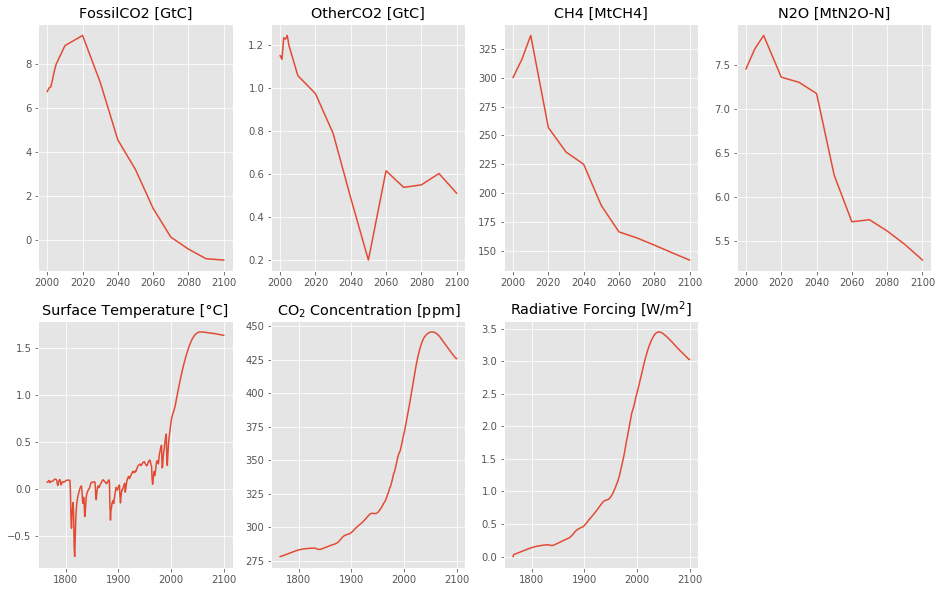

Output()

In [4]:
# Reference period
start = 1850
end = 1900

widget_scenario = widgets.Dropdown(
    title="Emissions Scenario", 
    value="RCP26",
    options=["RCP26", "RCP45", "RCP60", "RCP85"]
)

widget_status = widgets.HTML()

gases = pymagicc.rcp26["WORLD"].columns.values

widget_gas_1 = widgets.Dropdown(
    title="Emissions from", 
    value="FossilCO2",
    options=gases
)
widget_gas_2 = widgets.Dropdown(
    title="Emissions from", 
    value="OtherCO2",
    options=gases
)
widget_gas_3 = widgets.Dropdown(
    title="Emissions from", 
    value="CH4",
    options=gases
)
widget_gas_4 = widgets.Dropdown(
    title="Emissions from", 
    value="N2O",
    options=gases
)

style = {'description_width': 'initial'}
widget_core_climatesensitivity = widgets.FloatSlider(
    value=3, min=1.5, max=4.5, step=0.1, continuous_update=False,
    description="Climate Sensitivity",
    style=style
)

scen = pymagicc.scenarios["RCP26"]
data = scen["WORLD"]["FossilCO2"].loc[:2100]

widget_output = widgets.Output()

ui = widgets.VBox([
    widgets.HBox([widget_scenario,  widget_status]),
    widgets.HBox([widget_gas_1, widget_gas_2, widget_gas_3, widget_gas_4]),
    widget_core_climatesensitivity,
    widget_output])

def update(scenario, gas_1, gas_2, gas_3, gas_4, core_climatesensitivity):
    widget_status.value = "<em>Processing</em> …"
    scen = pymagicc.scenarios[scenario]
    data = scen["WORLD"].loc[:2100]
    data.index.name = ""
    results = run_pymagicc(scenario, core_climatesensitivity=core_climatesensitivity)
    
    fig, axes = plt.subplots(2, 4, figsize=(16,10))
    data[gas_1].plot(ax=axes[0, 0])
    axes[0, 0].set_title(gas_1 + " [" + pymagicc.units[gas_1] + "]")
    data[gas_2].plot(ax=axes[0, 1])
    axes[0, 1].set_title(gas_2  + " [" + pymagicc.units[gas_2] + "]")
    data[gas_3].plot(ax=axes[0, 2])
    axes[0, 2].set_title(gas_3 + " [" + pymagicc.units[gas_3] + "]")
    data[gas_4].plot(ax=axes[0, 3])
    axes[0, 3].set_title(gas_4 + " [" + pymagicc.units[gas_4] + "]")
    
    for key in results.keys():
        results[key].index.name = ""
    temp = results["SURFACE_TEMP"].GLOBAL
    temp = temp - temp.loc[start:end].mean()
    temp.plot(ax=axes[1, 0])
    axes[1, 0].set_title("Surface Temperature [°C]")
    
    results["CO2_CONC"].GLOBAL.plot(ax=axes[1, 1])
    axes[1, 1].set_title("CO$_2$ Concentration [ppm]")
    
    results["GHG_RF"].GLOBAL.plot(ax=axes[1, 2])
    axes[1, 2].set_title("Radiative Forcing [W/m$^2$]")
    
    axes[1, 3].remove()
    widget_status.value = ""

out = widgets.interactive_output(
    update, 
    {
        "scenario": widget_scenario, 
        "gas_1": widget_gas_1,
        "gas_2": widget_gas_2,
        "gas_3": widget_gas_3,
        "gas_4": widget_gas_4,
        "core_climatesensitivity": widget_core_climatesensitivity
    }
)
    
display(ui, out)

Surface temperature is relative to the pre-industrial 1850-1900 period.